In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime

# Time Series

Taking a dataset for Russia personnel losses at special military operation in Ukraine (up to 21 of May)

In [137]:
data = pd.read_csv('russia_losses_personnel.csv')
data.head()

,date,day,personnel,personnel*,POW
0,2022-02-25,2,2800,about,0
1,2022-02-26,3,4300,about,0
2,2022-02-27,4,4500,about,0
3,2022-02-28,5,5300,about,0
4,2022-03-01,6,5710,about,200


Deaths are accumulated, so we get diff() for each day

In [138]:
data['deaths'] = data.personnel.diff() # Get deaths by a day
data['deaths'][0] = data['personnel'][0]
data

<ipython-input-138-22e01d259360>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['deaths'][0] = data['personnel'][0]


,date,day,personnel,personnel*,POW,deaths
0,2022-02-25,2,2800,about,0,2800.0
1,2022-02-26,3,4300,about,0,1500.0
2,2022-02-27,4,4500,about,0,200.0
3,2022-02-28,5,5300,about,0,800.0
4,2022-03-01,6,5710,about,200,410.0
...,...,...,...,...,...,...
81,2022-05-17,83,27900,about,498,200.0
82,2022-05-18,84,28300,about,498,400.0
83,2022-05-19,85,28500,about,498,200.0
84,2022-05-20,86,28700,about,498,200.0


In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        86 non-null     object 
 1   day         86 non-null     int64  
 2   personnel   86 non-null     int64  
 3   personnel*  86 non-null     object 
 4   POW         86 non-null     int64  
 5   deaths      86 non-null     float64
dtypes: float64(1), int64(3), object(2)
memory usage: 4.2+ KB


In [140]:
data['date'] = pd.to_datetime(data['date'])

In [141]:
data.index = data['date']

Removing all unnecessary columns - we will consider only deaths

In [142]:
del data['date']
del data['day']
del data['personnel']
del data['personnel*']
del data['POW']
data

,deaths
date,
2022-02-25,2800.0
2022-02-26,1500.0
2022-02-27,200.0
2022-02-28,800.0
2022-03-01,410.0
...,...
2022-05-17,200.0
2022-05-18,400.0
2022-05-19,200.0


### Deaths by day

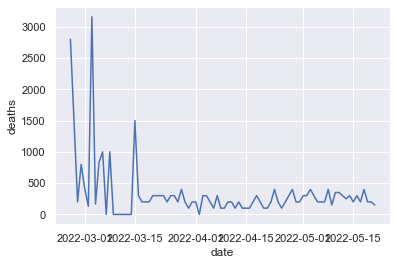

In [143]:
sns.lineplot(data=data, x=data.index, y=data['deaths'])

Based on this plot, we can say that since 15 of March deaths are rather stable without any significant increase or decrease. From 24.02 to 15.03 there was a very high dispersion from 3000+ to 0 (0 is present probably due to absence of data - thus there is such a peak after these 0-data at 15.03). In general, it is very difficult to tell anything about the trend - probably there is a small downward trend from the beginning of the operation up to current days. Seasonality is not very seen there. Difficult to say something about cyclicality - probably there is no cyclicality in data.

### Deaths by day of the week

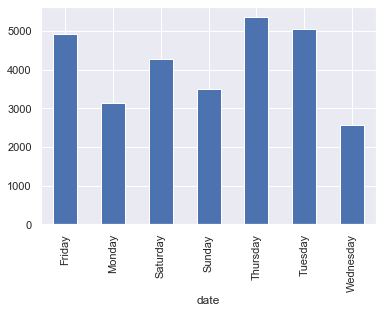

In [144]:
data.groupby(data.index.day_name()).sum().deaths.plot(kind = 'bar')

From the data given, it is seen that the most deadly days are Thursday, Tuesday and Friday - but these days can be influenced by the first days of the special operation (it can be definitly said about Thursday - the day, when the opearation started: according to the data, there are 2800 days in the first day of operation).

## Removing outliers:

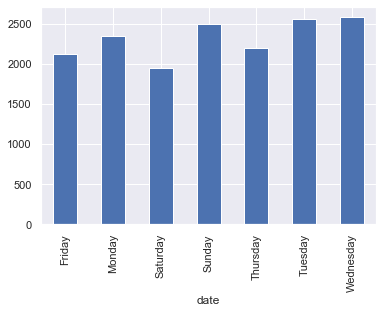

In [145]:
data.loc[(data.deaths > 0) & (data.deaths < 500)].groupby(data.loc[(data.deaths > 0) & (data.deaths < 500)].index.day_name()).sum().deaths.plot(kind = 'bar')

Deaths appear to be quite stable throughout a week. Tuesday and Wednesday are the most deadly days

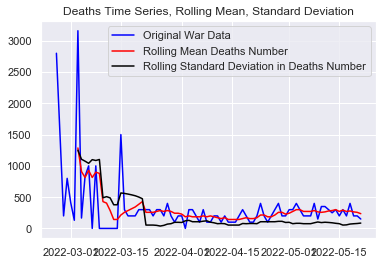

In [146]:
plt.plot(data, color="blue",label="Original War Data") 
rolling_mean = data.rolling(7).mean() 
plt.plot(rolling_mean, color="red", label="Rolling Mean Deaths Number") 
rolling_std = data.rolling(7).std()
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Deaths Number")
plt.title("Deaths Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

Based on the rolling mean there is certainly a decreasing trend at the beginning and a plateau since the end of March. The distribution is of the hyperbolic form. Standard deviation is very high at the beginning of the operation and becomes quite low since the end of March.

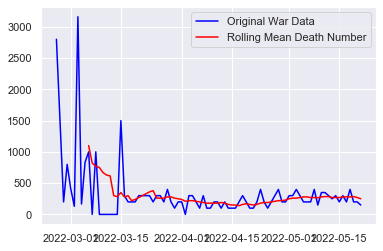

In [147]:
plt.plot(data, color="blue",label="Original War Data") 
rolling_mean = data.rolling(10).mean() #10-day rolling mean 
plt.plot(rolling_mean, color="red", label="Rolling Mean Death Number") 
plt.legend(loc="best")

Current plot with a rolling mean for 10 days also shows nearly the same situation and a hyperbolic distribution

## Stationarity

Hypothesis:

- H0: there is no stationarity in the data.
- H1: there is stationarity in data

p-value: 0.05

### Dickey Fuller test 

In [148]:
from statsmodels.tsa.stattools import adfuller
adft = adfuller(data,autolag="AIC")
print('p-value: ', adft[1])

p-value:  0.004037779346108405


According to the results of Dickey Fuller test, the data is very **stationary**: we reject H0 at p-value 0.05 (and can reject it even at 0.005)

We can check stationarity at different lags, but it obviously will also be stationary, but let us check:

In [149]:
data['deaths_dif1'] = data['deaths'] - data['deaths'].shift(1) #one lag differencing
adft = adfuller(data['deaths_dif1'].dropna(),autolag="AIC")
print('p-value: ', adft[1])

p-value:  5.488637530850071e-07


In [150]:
data['deaths_dif7'] = data['deaths'] - data['deaths'].shift(7) #seven lags differencing
adft = adfuller(data['deaths_dif7'].dropna(),autolag="AIC")
print('p-value: ', adft[1])

p-value:  9.677018685222607e-05


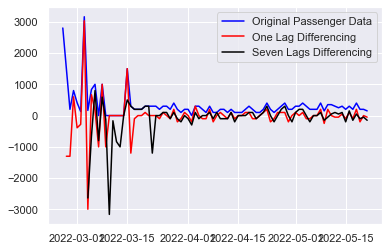

In [151]:
plt.plot(data['deaths'], color="blue",label="Original Passenger Data")
plt.plot(data['deaths_dif1'], color="red", label="One Lag Differencing")
plt.plot(data['deaths_dif7'], color="black", label = "Seven Lags Differencing") 
plt.legend(loc="best")

Due to high dispersion of deaths in the first days, 1- and 7-day lag differencing have also high dispersion at the beginning, but become rather stable since the end of March

### Autocorrelation

Let us check correlation of a series with its own lags

In [152]:
autocorrelation_lag1 = data['deaths'].autocorr(lag=1)
print("One Day Lag: ", autocorrelation_lag1)

One Day Lag:  0.12759750661492564


In [153]:
autocorrelation_lag2 = data['deaths'].autocorr(lag=2)
print("Two Days Lag: ", autocorrelation_lag2)

Two Days Lag:  0.15378948215295707


In [154]:
autocorrelation_lag3 = data['deaths'].autocorr(lag=3)
print("Three Days Lag: ", autocorrelation_lag3)

Three Days Lag:  0.312767144102866


In [155]:
autocorrelation_lag5 = data['deaths'].autocorr(lag=5)
print("Five Days Lag: ", autocorrelation_lag5)

Five Days Lag:  0.3309841840042108


In [156]:
autocorrelation_lag7 = data['deaths'].autocorr(lag=7)
print("Seven Days Lag: ", autocorrelation_lag7)

Seven Days Lag:  0.06413594261200327


We can see that the data very weakly correlate with its lags: the highest correlations are found at lags 3 and 5. Correlations at lags 3 and 5 are weak, whereas correlations at other examined lags are either very weak or even less.

Trends of correlations of the series with its lags are presented on the following plots:

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


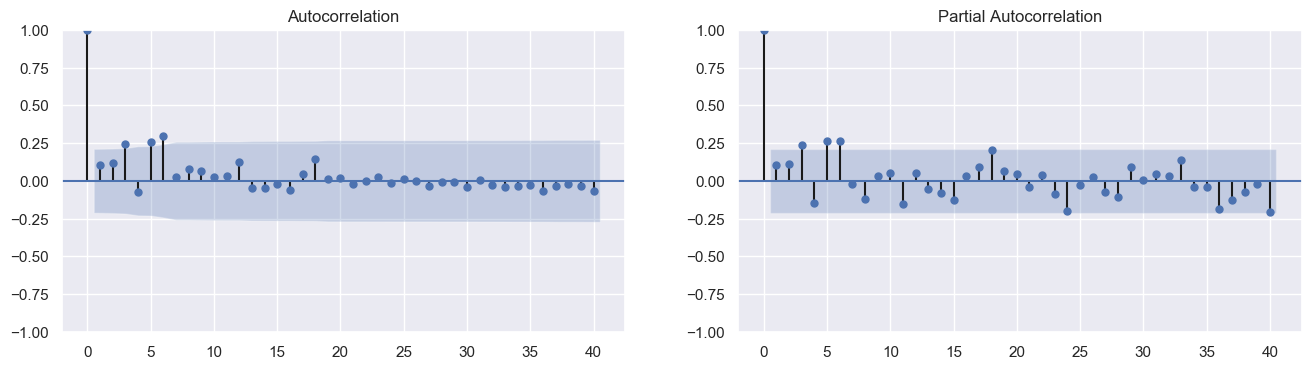

In [157]:
fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 100)
plot_acf(data['deaths'], lags=40, ax=axes[0])
plot_pacf(data['deaths'], lags=40, ax=axes[1])
plt.show()

It is seen that there is a very weak autocorrelation of the given time series.

## Forecasting

In [158]:
data = data.drop(['deaths_dif1','deaths_dif7'], axis = 1)

In [159]:
train = data[data.index < datetime.datetime(2022,4,30)]

In [160]:
train = train.rename(columns = {'deaths' : 'train'})
train

,train
date,
2022-02-25,2800.0
2022-02-26,1500.0
2022-02-27,200.0
2022-02-28,800.0
2022-03-01,410.0
...,...
2022-04-25,100.0
2022-04-26,200.0
2022-04-27,300.0


In [161]:
test = data[data.index >= datetime.datetime(2022,4,30)]
test = test.rename(columns = {'deaths' : 'test'})
test

,test
date,
2022-04-30,200.0
2022-05-01,300.0
2022-05-02,300.0
2022-05-03,400.0
2022-05-04,300.0
2022-05-05,200.0
2022-05-06,200.0
2022-05-07,200.0
2022-05-08,400.0


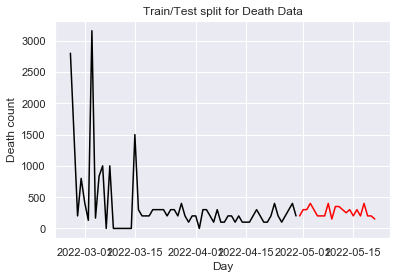

In [162]:
plt.plot(train, color = "black")
plt.plot(test, color = "red") 
plt.title("Train/Test split for Death Data")
plt.ylabel("Death count")
plt.xlabel('Day')
sns.set()
plt.show()

Although the series is stationary, ARIMA can still be used, but we need to replace d-parameter with 0:

In [163]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, d = 0)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=995.497, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=996.511, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=996.729, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1015.600, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=992.412, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=993.479, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=997.360, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=995.975, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=996.980, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=992.086, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1011.031, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1007.193, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=993.225, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=993.02

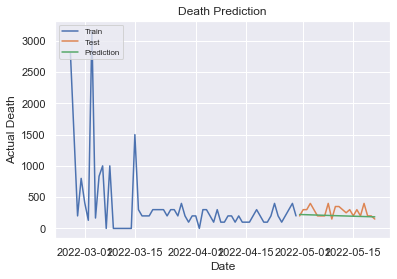

In [164]:
plt.plot(train, label='Train') 
plt.plot(test, label='Test') 
plt.plot(forecast, label='Prediction') 

plt.title('Death Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Death')
plt.legend(loc='upper left', fontsize=8)
plt.show()

As is seen from the plot, the model predicts a correct trend regarding the deaths but does not predict variance of deaths number

For curiosity, we try to run ARIMA without predefined d (so to presume that the data is not stationary):

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=977.515, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1006.004, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=986.320, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=969.708, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1004.230, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=970.723, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=970.492, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=969.709, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.865 seconds


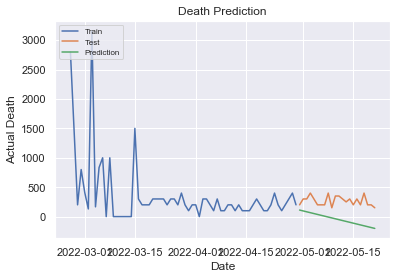

In [165]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

plt.plot(train, label='Train') 
plt.plot(test, label='Test') 
plt.plot(forecast, label='Prediction') 

plt.title('Death Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Death')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The results are much worse and the latter model cannot really predict deaths number (at some point it even starts to predict negative number of deaths)

In [166]:
data.index = pd.DatetimeIndex(data.index.values, freq=data.index.inferred_freq)

In [167]:
from statsmodels.tsa.arima.model import ARIMA
model  =  ARIMA(data['deaths'], order=(1, 0, 1))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                 deaths   No. Observations:                   86
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -648.967
Date:                Sun, 22 May 2022   AIC                           1305.933
Time:                        20:50:32   BIC                           1315.750
Sample:                    02-25-2022   HQIC                          1309.884
                         - 05-21-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        484.0011    461.796      1.048      0.295    -421.103    1389.105
ar.L1          0.9723      0.033     29.148      0.000       0.907       1.038
ma.L1         -0.8192      0.066    -12.341      0.0

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


It is seen that data with lag 1 significantly influences the actual data in the model since the coefficient is 0.97. The coefficient for an error at lag 1 is also very high: -0.81.

#### Residuals

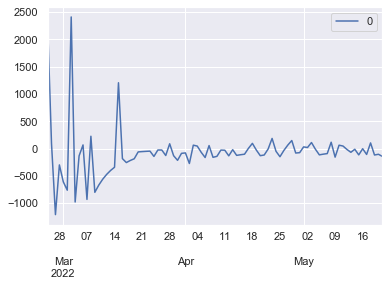

In [168]:
residuals = pd.DataFrame(res.resid)
residuals.plot()

Obviously, residuals are very high at the beginning of the special operation and become much less to the current days

### Conclusions

Constructed ARMA-model can successfuly predict the trend of deaths at special military operation in Ukraine but cannot capture variation within days. According to the model, the number of deaths in future days would be quite stable. The model has high residuals at first days, since in some days number of deaths was very high and in some days there was no information. Probably, a good tip would be to fill 0 deaths in the dataset with some data: a proper approach would be to get the quantity of the day after these zeros and redistribute this quantity over these 0-days and this day.
As for the data itself, it is seen that the number of deaths per day is rather stationary. The autocorrelation is quite small, so deaths barely depend on some lags: the correlation is either very weak or weak.